In [21]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
from pathlib import Path
import pickle
import logging
from dotenv import dotenv_values
import pdb
from pprint import pprint
import json


import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.serializers import JSONSerializer


INPUT_MODE = 'File'  # File or Pipe
MAX_TRAIN_JOBS = 10
MAX_PARRALLEL_JOBS = 1
INSTANCE_TYPE_TRAIN = "ml.c4.4xlarge"
INSTANCE_TYPE_PREDICT = "ml.m5.xlarge"
INSTANCE_COUNT_BATCH_TRANSFORM = 4
OBJECTIVE_METRIC_NAME = "validation:accuracy"  # Only option for BlazingText Classification
OBJECTIVE_TYPE = "Maximize"

config = dotenv_values(".env")
BUCKET = config['BUCKET']


logger = logging.getLogger(__name__)

sm_client = boto3.client('sagemaker')
s3_client = boto3.client('s3')
role = sagemaker.get_execution_role()
session = boto3.Session()
region_name = session.region_name
image_uri = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [18]:
# Load test data
# ==============
with open('data/df_test.pickle', 'rb') as f:
    df_test: pd.DataFrame = pickle.load(f)


# Load model
# ==========
with open('data/tuning_job_name.pickle', 'rb') as f:
    best_tuning_job_name = pickle.load(f)

tuner = HyperparameterTuner.attach(
    tuning_job_name=best_tuning_job_name,
    # sagemaker_session=session,
)


# Deploy best model
# =================
# Load model name
with open('data/model_name.pickle', 'rb') as file:
    name_of_best_model = pickle.load(file=file)

# Todo: Create deployment from model name to standardize w/ Batch Transform
deployed_model = tuner.deploy(
    initial_instance_count=1,
    instance_type=INSTANCE_TYPE_PREDICT, 
    serializer=JSONSerializer()
)

In [22]:
# Make predictions and extract probability of reply
# =================================================
def _prediction_to_df_row(pred: dict) -> dict:
    labels = pred['label']
    probs = pred['prob']
    return {
        label: prob 
        for label, prob in zip(labels, probs)
    }

def get_probs(text: np.array, deployed_model) -> list[np.float]:
    payload = {
        "instances": text,
        "configuration": {"k": 2},  # get probs for top-k (both) classes
    }
    response = deployed_model.predict(payload)
    predictions = json.loads(response)

    all_probs = [
        _prediction_to_df_row(pred) for pred in predictions
    ]
    return pd.DataFrame(all_probs)['__label__reply']

# Probability of reply for messages that actually received a reply
replied_tos = df_test.loc[df_test.label == '__label__reply', 'feature'].values
p_reply = get_probs(replied_tos, deployed_model=deployed_model)
p_reply.describe()

# Probability of reply for messages that did NOT received a reply
no_reply = df_test.loc[df_test.label == '__label__no_reply', 'feature'].values
p_no_reply = pd.concat(
    [
        # Need to make 2 separate requests
        get_probs(no_reply[:2000], deployed_model=deployed_model),
        get_probs(no_reply[2000:], deployed_model=deployed_model)
    ],
    axis=0
)
p_no_reply.describe()

count    3632.000000
mean        0.210332
std         0.236586
min         0.000010
25%         0.040223
50%         0.101334
75%         0.320263
max         0.996125
Name: __label__reply, dtype: float64

Let's compare how our predictions for those emails that actually received a reply differ from those that did not receive a reply. To do so, we'll estimate the probability density function from the predictions and plot it:

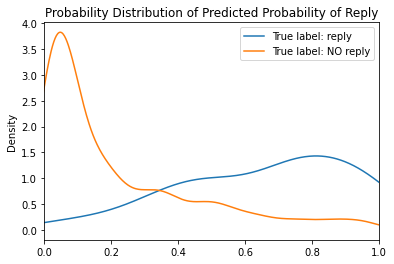

In [53]:
# Kernel-density estimation
p_reply.plot.kde(
    xlim = (0,1),
    label='True label: reply',
    xlabel='categories'

)
p_no_reply.plot.kde(
    xlim = (0,1),
    label='True label: NO reply',
    title='Probability Distribution of Predicted Probability of Reply'
)
plt.legend()
plt.show();

We see that our model performs much better at identifying emails that did not receive a reply. By contrast, it is less confident when identifying emails that do receive a reply. This is as expected, as we have much fewer training examples for emails that elicit a reply.

In [23]:
# Cleanup
deployed_model.delete_predictor()